# META Monte Carlo Simulation

### Table of Contents

- [**Parameter Extraction From Excel & Standard Deviation Assumptions**](#params)
    - [Function : Random Normal Variable for WACC and Terminal Growth Rate](#function1)
    - [Function : Calculate Implied Stock Price and Enterprise Value](#function2)
- [**Monte Carlo Simulation**](#Monte)
- [**Visualizations**](#Visualizations)
    - [Histograms of Implied Enterpirse Value and Implied Stock Price](#histogram)
     - [Quantiles ](#quantiles)

## Imports

In [2]:
import xlwings as xw
import pandas as pd
import random as rand
import numpy_financial as npf
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-dark")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# <a id='params'>Parameter Extraction From Excel & Standard Deviation Assumptions</a>

Below we connect to the DCF Model in Excel. From this Model we will extract all the relevant information necessary to run the monte Carlo Simulation.

In [2]:
operating_model = xw.Book("Meta Operating Model V.1.xlsx")
dcf_sheet = operating_model.sheets['DCF']

Below we create a data class which will extract all relevant values needed for calculating the Implied Stock Price From the DCF Model. We Also define assumptions for the WACC and Terminal Growth Rate. These two rates will be normally distributed for n iterations to analyze their effect on the Implied Stock price.

In [3]:
@dataclass
class Model:
    wacc_expected_value :float = dcf_sheet.range('E16').value
    terminal_growth_rate_expected_value :float = dcf_sheet.range('E17').value
    free_cash_flows_to_firm  = dcf_sheet.range('D33:H33').value
    cash_cash_equivalents :float = dcf_sheet.range('H49').value
    marketable_sec :float = dcf_sheet.range('H50').value
    long_term_debt :float = dcf_sheet.range('H51').value
    shares_out_standing :float = dcf_sheet.range('H53').value
    wacc_stdev :float = 0.0125
    terminal_growth_rate_stdev :float = 0.005

Below we create an instance of the Model class which will be used mainly as a function parameter nad easy way access properties from the data class

In [4]:
data = Model()

### <a id='function1'>Function for Normal Random Variables : Terminal Growth Rate and WACC</a>

In [5]:
def rand_wacc(data) :
    return rand.normalvariate(data.wacc_expected_value,data.wacc_stdev)

def rand_tgr (data) :
    return rand.normalvariate(data.terminal_growth_rate_expected_value,data.terminal_growth_rate_stdev)

### <a id='function2'>Function(s) for Calculating Implied Enterprise Value and Stock Price With Model Data</a>

Below are the functions which will be utilized to run the simulations. The Functions below are built to reflect the current Excel Model Out put to confirm that it is functioning as intended. Later These functions will be modified to expect random values for the WACC and Terminal Growth Rate.

In [6]:
def implied_enterprise_value (data):
    g_rate = data.terminal_growth_rate_expected_value
    wacc = data.wacc_expected_value
    new_fcff_list = [x for x in data.free_cash_flows_to_firm]
    terminal_value = (new_fcff_list[-1]*(1+g_rate)/(wacc - g_rate))
    new_fcff_list[-1] = new_fcff_list[-1]+ terminal_value
    enterprise_value = npf.npv(wacc,[0] + new_fcff_list)
    return enterprise_value
implied_enterprise_value(data)

300495.86207288445

In [7]:
def implied_stock_price (data):
    enterpise_val = implied_enterprise_value (data)
    cash_equiv = data.cash_cash_equivalents
    mark_sec = data.marketable_sec
    debt = data.long_term_debt
    shares= data.shares_out_standing
    stock_price = (enterpise_val + cash_equiv+mark_sec+debt)/shares
    return stock_price
implied_stock_price (data)

122.61689936080106

# <a id='Monte'>Monte Carlo Simulation</a>

In [8]:
n_iterations = 10000

In [9]:
def enterprise_value_stock_price(data):
    table = []
    for i in range(n_iterations):
        g_rate = rand_tgr(data)
        wacc = rand_wacc (data)
        new_fcff_list = [x for x in data.free_cash_flows_to_firm]
        terminal_value = (new_fcff_list[-1]*(1+g_rate)/(wacc - g_rate))
        new_fcff_list[-1] = new_fcff_list[-1]+ terminal_value
        enterprise_value = npf.npv(wacc,[0] + new_fcff_list)
        
        cash_equiv = data.cash_cash_equivalents
        mark_sec = data.marketable_sec
        debt = data.long_term_debt
        shares= data.shares_out_standing
        stock_price = (enterprise_value + cash_equiv+mark_sec+debt)/shares
        
        table.append((wacc,g_rate,enterprise_value,stock_price))
    
    df = pd.DataFrame(table,columns=["WACC","Terminal Growth Rate", "Implied Enterprise Value","Implied Stock Price"])
    return df
    
monte_carlo_df = enterprise_value_stock_price(data)
monte_carlo_df

,WACC,Terminal Growth Rate,Implied Enterprise Value,Implied Stock Price
0,0.126254,0.022785,224997.531831,94.675252
1,0.097693,0.032403,355296.339027,142.898349
2,0.117337,0.027861,258557.079415,107.095514
3,0.122131,0.037570,265912.983138,109.817906
4,0.102142,0.019211,288542.600549,118.193042
...,...,...,...,...
9995,0.120419,0.038044,272952.396267,112.423167
9996,0.119600,0.026580,249105.777327,103.597623
9997,0.099657,0.032314,344041.651355,138.733032
9998,0.123781,0.032559,249422.237103,103.714744


## <a id='Visualizations'>Visualizations</a>

In [10]:
def styled_df(df):
    return df.style.format({
        'WACC': '{:.2%}',
        'Terminal Growth Rate': '{:.2%}',
        'Implied Enterprise Value': '${:,.2f}',
        'Implied Stock Price': '${:,.2f}'
    }).background_gradient(cmap='RdYlGn',subset=['Implied Stock Price'])

In [11]:
styled_df(monte_carlo_df.head(10))

,WACC,Terminal Growth Rate,Implied Enterprise Value,Implied Stock Price
0,12.63%,2.28%,"$224,997.53",$94.68
1,9.77%,3.24%,"$355,296.34",$142.90
2,11.73%,2.79%,"$258,557.08",$107.10
3,12.21%,3.76%,"$265,912.98",$109.82
4,10.21%,1.92%,"$288,542.60",$118.19
5,9.60%,3.18%,"$362,272.50",$145.48
6,11.75%,2.59%,"$253,808.21",$105.34
7,9.48%,2.78%,"$351,178.68",$141.37
8,11.53%,3.75%,"$290,319.95",$118.85
9,11.32%,2.65%,"$268,551.64",$110.79


# <a id='histogram'>Histograms </a>

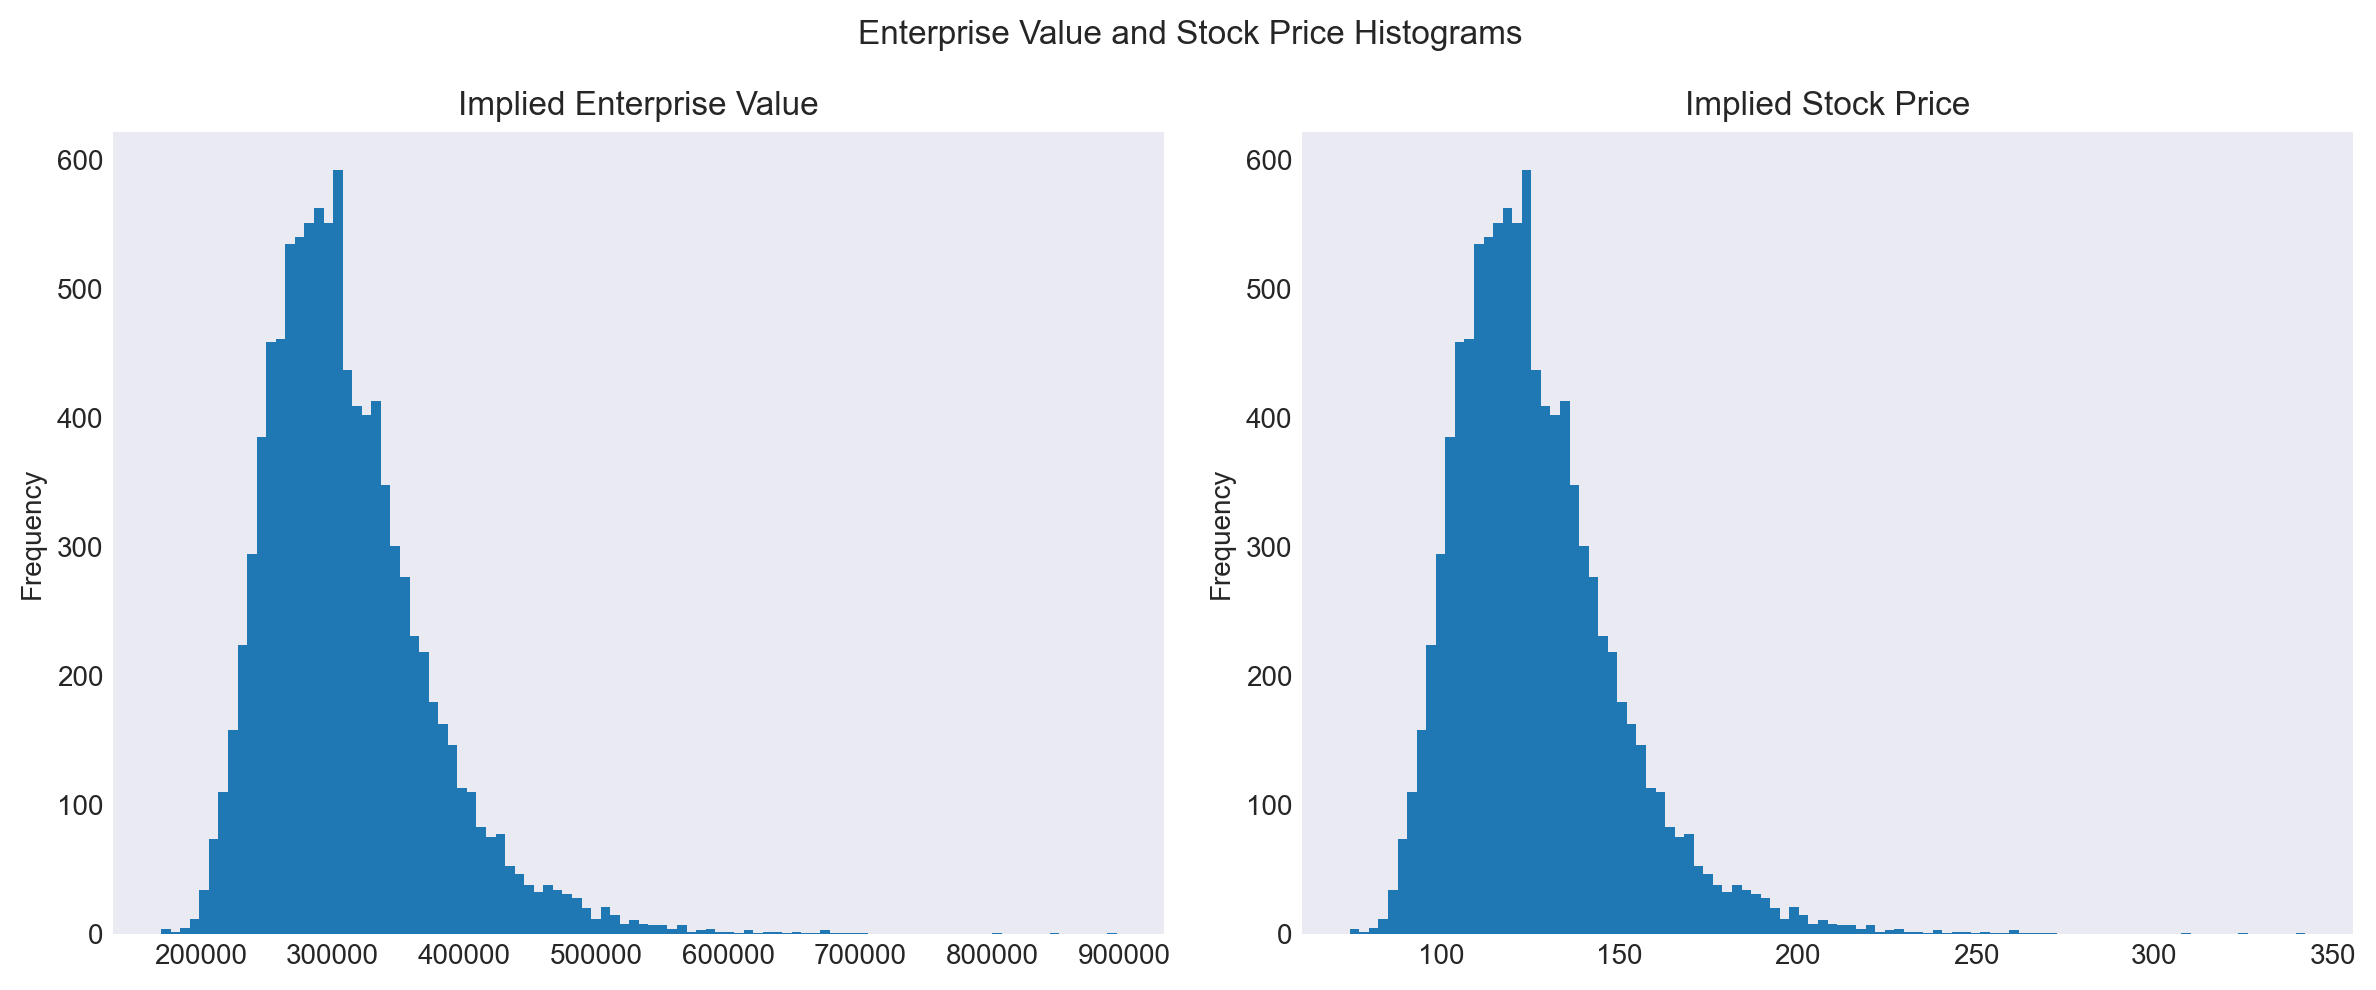

In [12]:
plt.figure(figsize=(12,5),dpi=200)
plt.suptitle("Enterprise Value and Stock Price Histograms")

plt.subplot(1,2,1)
monte_carlo_df["Implied Enterprise Value"].plot(kind="hist",bins = 100)
plt.title("Implied Enterprise Value")

plt.subplot(1,2,2)
monte_carlo_df["Implied Stock Price"].plot(kind="hist", bins = 100)
plt.title("Implied Stock Price")

plt.tight_layout()

## <a id='quantiles'>Quantiles</a>

In [13]:
quantile = monte_carlo_df.quantile([i / 20 for i in range(1, 20)])
styled_df(quantile)

,WACC,Terminal Growth Rate,Implied Enterprise Value,Implied Stock Price
0.050000,8.67%,2.21%,"$231,904.22",$97.23
0.100000,9.08%,2.38%,"$244,123.94",$101.75
0.150000,9.40%,2.49%,"$253,046.22",$105.06
0.200000,9.67%,2.59%,"$260,867.37",$107.95
0.250000,9.86%,2.67%,"$267,979.86",$110.58
0.300000,10.05%,2.74%,"$274,752.73",$113.09
0.350000,10.23%,2.81%,"$281,457.24",$115.57
0.400000,10.39%,2.88%,"$287,951.82",$117.97
0.450000,10.55%,2.94%,"$294,520.03",$120.41
0.500000,10.70%,3.00%,"$300,873.66",$122.76
